In [1]:
from skimage.io import imread
from skimage.transform import resize
from skimage import img_as_float
import numpy as np
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Input, concatenate, UpSampling2D
from keras.optimizers import Adam
from keras.initializers import he_normal
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16


def unet(input_size = (256,256,3), seed=42, base = 32, actv='relu'):
    inputs = Input(input_size)
    kern_init = kernel_initializer=he_normal(seed=seed)
    conv1 = Conv2D(base,    3, activation=actv, padding='same', )(inputs)
    conv1 = Conv2D(base,    3, activation=actv, padding='same', kernel_initializer=kern_init)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(base*2,  3, activation=actv, padding='same', kernel_initializer=kern_init)(pool1)
    conv2 = Conv2D(base*2,  3, activation=actv, padding='same', kernel_initializer=kern_init)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(base*4,  3, activation=actv, padding='same', kernel_initializer=kern_init)(pool2)
    conv3 = Conv2D(base*4,  3, activation=actv, padding='same', kernel_initializer=kern_init)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(base*8,  3, activation=actv, padding='same', kernel_initializer=kern_init)(pool3)
    conv4 = Conv2D(base*8,  3, activation=actv, padding='same', kernel_initializer=kern_init)(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(base*16, 3, activation=actv, padding='same', kernel_initializer=kern_init)(pool4)
    conv5 = Conv2D(base*16, 3, activation=actv, padding='same', kernel_initializer=kern_init)(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6   = Conv2D(base*8,  2, activation=actv, padding='same', kernel_initializer=kern_init)(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(base*8,  3, activation=actv, padding='same', kernel_initializer=kern_init)(merge6)
    conv6 = Conv2D(base*8,  3, activation=actv, padding='same', kernel_initializer=kern_init)(conv6)

    up7   = Conv2D(base*4,  2, activation=actv, padding='same', kernel_initializer=kern_init)(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(base*4,  3, activation=actv, padding='same', kernel_initializer=kern_init)(merge7)
    conv7 = Conv2D(base*4,  3, activation=actv, padding='same', kernel_initializer=kern_init)(conv7)

    up8   = Conv2D(base*2,  2, activation=actv, padding='same', kernel_initializer=kern_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(base*2,  3, activation=actv, padding='same', kernel_initializer=kern_init)(merge8)
    conv8 = Conv2D(base*2,  3, activation=actv, padding='same', kernel_initializer=kern_init)(conv8)

    up9   = Conv2D(base,    2, activation=actv, padding='same', kernel_initializer=kern_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(base,    3, activation=actv, padding='same', kernel_initializer=kern_init)(merge9)
    conv9 = Conv2D(base,    3, activation=actv, padding='same', kernel_initializer=kern_init)(conv9)
    conv9 = Conv2D(2,       3, activation=actv, padding='same', kernel_initializer=kern_init)(conv9)
    conv10 = Conv2D(1,      1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model


def unet_vgg16(input_size = (256,256,3), seed=42, pretrained_weights = None, actv='relu'):
    inputs = Input(input_size)
    kern_init = kernel_initializer=he_normal(seed=seed)
    conv1 = Conv2D(64,  3, activation=actv, padding='same', )(inputs)
    conv1 = Conv2D(64,  3, activation=actv, padding='same', kernel_initializer=kern_init)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation=actv, padding='same', kernel_initializer=kern_init)(pool1)
    conv2 = Conv2D(128, 3, activation=actv, padding='same', kernel_initializer=kern_init)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation=actv, padding='same', kernel_initializer=kern_init)(pool2)
    conv3 = Conv2D(256, 3, activation=actv, padding='same', kernel_initializer=kern_init)(conv3)
    conv3 = Conv2D(256, 3, activation=actv, padding='same', kernel_initializer=kern_init)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation=actv, padding='same', kernel_initializer=kern_init)(pool3)
    conv4 = Conv2D(512, 3, activation=actv, padding='same', kernel_initializer=kern_init)(conv4)
    conv4 = Conv2D(512, 3, activation=actv, padding='same', kernel_initializer=kern_init)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation=actv, padding='same', kernel_initializer=kern_init)(pool4)
    conv5 = Conv2D(512, 3, activation=actv, padding='same', kernel_initializer=kern_init)(conv5)
    conv5 = Conv2D(512, 3, activation=actv, padding='same', kernel_initializer=kern_init)(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6   = Conv2D(512, 2, activation=actv, padding='same', kernel_initializer=kern_init)(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation=actv, padding='same', kernel_initializer=kern_init)(merge6)
    conv6 = Conv2D(512, 3, activation=actv, padding='same', kernel_initializer=kern_init)(conv6)

    up7   = Conv2D(256, 2, activation=actv, padding='same', kernel_initializer=kern_init)(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation=actv, padding='same', kernel_initializer=kern_init)(merge7)
    conv7 = Conv2D(256, 3, activation=actv, padding='same', kernel_initializer=kern_init)(conv7)

    up8   = Conv2D(128, 2, activation=actv, padding='same', kernel_initializer=kern_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation=actv, padding='same', kernel_initializer=kern_init)(merge8)
    conv8 = Conv2D(128, 3, activation=actv, padding='same', kernel_initializer=kern_init)(conv8)

    up9   = Conv2D(64,  2, activation=actv, padding='same', kernel_initializer=kern_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64,  3, activation=actv, padding='same', kernel_initializer=kern_init)(merge9)
    conv9 = Conv2D(64,  3, activation=actv, padding='same', kernel_initializer=kern_init)(conv9)
    conv9 = Conv2D(2,   3, activation=actv, padding='same', kernel_initializer=kern_init)(conv9)
    conv10 = Conv2D(1,  1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

    for i in range(len(vgg_conv.layers)):
        weights = vgg_conv.layers[i].get_weights()
        layer = model.layers[i]
        layer.set_weights(weights)
        layer.trainable = False

    return model


def iou(y_true, y_pred):
    smooth=1e-5
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

Using TensorFlow backend.


In [2]:
model = unet_vgg16(input_size=(256, 256, 3))

/home/dmitry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [6]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [2]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import skimage.io as io
import skimage.transform as trans


def trainGenerator(
    batch_size,
    image_path,
    mask_path,
    aug_dict,
    image_color_mode = "rgb",
    mask_color_mode = "grayscale",
    target_size = (256,256),
    seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(
        rescale=1./255,
        samplewise_center=True,
        samplewise_std_normalization=True,
        **aug_dict)
    mask_datagen = ImageDataGenerator(rescale=1./255, **aug_dict)
    image_generator = image_datagen.flow_from_directory(
        image_path,
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        interpolation='bilinear',
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        mask_path,
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        interpolation='bilinear',
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        yield (img,mask)

In [4]:
target_size=(256,256)
data_gen_args = dict(
    rotation_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest')
myGene = trainGenerator(
    batch_size=2,
    image_path='public_tests/00_test_val_input/train/images',
    mask_path='public_tests/00_test_val_input/train/gt',
    aug_dict=data_gen_args,
    target_size=target_size)
#model = unet(input_size=(None, None, 3), base=64)
model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss',verbose=1, save_best_only=True)

In [5]:
for layer in model.layers:
    layer.trainable = True
model.compile(optimizer = Adam(lr = 1e-5), loss = 'binary_crossentropy', metrics = ['accuracy', iou])
model.fit_generator(
    myGene,
    steps_per_epoch=2,
    epochs=1)

Epoch 1/1
Found 8382 images belonging to 200 classes.
Found 8382 images belonging to 200 classes.
2/2 [==============================] - 47s 23s/step - loss: 0.7458 - accuracy: 0.7689 - iou: 0.1176


In [86]:
model.fit_generator(myGene,steps_per_epoch=2,epochs=1)

Epoch 1/1
2/2 [==============================] - 30s 15s/step - loss: 6.0755


In [87]:
model.save('model.hdf5')

In [3]:
%matplotlib inline
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage import img_as_float

target_size = (256, 256)

def predict(model, img_path):
    img = img_as_float(imread(img_path))
    shape = img.shape
    inp = resize(img, target_size)
    if len(inp.shape) == 2:
        inp = np.array([inp, inp, inp]).transpose((1,2,0))
    inp -= inp.mean()
    inp /= inp.std()
    result = model.predict(np.array([inp]))[0]
    return resize(result, shape)[...,0]

In [4]:
img_path0 = 'public_tests/00_test_val_input/test/images/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg'
img_path1 = 'public_tests/00_test_val_input/test/images/009.Brewer_Blackbird/Brewer_Blackbird_0046_2688.jpg'
img_path2 = 'photo_2019-12-01_19-30-14.jpg'

In [5]:
from tensorflow.keras.models import load_model
model = load_model('segmentation_model.hdf5')

In [96]:
model = load_model(
    'segmentation_model.hdf5',
    custom_objects={'iou': iou})

model.compile(optimizer = 'adam', loss = 'binary_crossentropy')

model.save('segmentation_model.hdf5')

OSError: SavedModel file does not exist at: segmentation_model.hdf5/{saved_model.pbtxt|saved_model.pb}

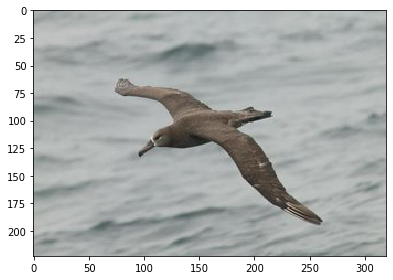

In [36]:
imshow(imread(img_path0))

In [6]:
def show_segm(model, img_path):
    img = img_as_float(imread(img_path)).transpose((2,0,1))
    segm = predict(model, img_path) > 0.5
    alpha = 0.5
    green = np.array([np.zeros_like(segm), np.ones(segm.shape), np.zeros_like(segm)])
    res = (1 - segm) * img + segm * (img * (1-alpha) + green * alpha)
    imshow(res.transpose((1,2,0)))

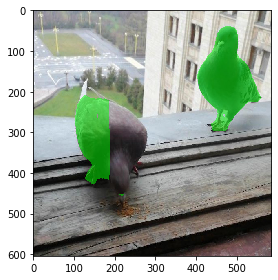

In [30]:
show_segm(model, img_path2)

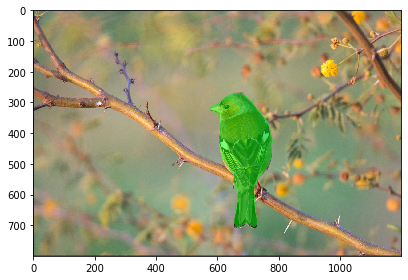

In [28]:
show_segm(model, "644124_main.jpg")

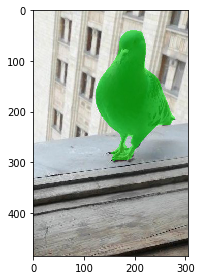

In [26]:
show_segm(model, "photo_2019.jpg")

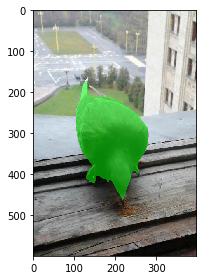

In [24]:
show_segm(model, "photo_20191.jpg")

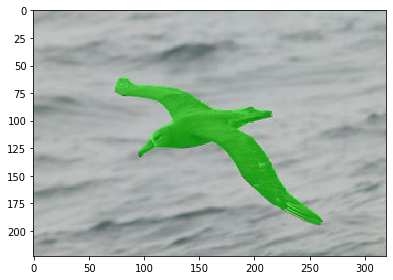

In [23]:
show_segm(model, img_path0)

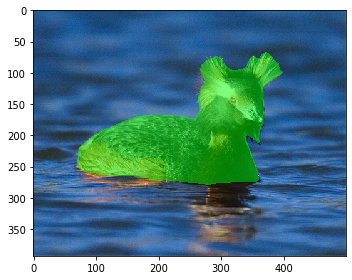

In [42]:
show_segm(
    model,
    'file:///home/dmitry/Study/ComputerVision/10-BirdsSegmentation/public_tests/00_test_val_input/test/images/051.Horned_Grebe/Horned_Grebe_0046_34926.jpg'
)

In [17]:
 model1 = load_model('models/segmentation_model_7981.hdf5')